In [1]:
%load_ext lab_black

In [12]:
import math

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import triton
import triton.language as tl
from torch import Tensor
from torch.autograd.function import Function

__all__ = ["geglu", "GEGLU"]

_kAlpha = math.sqrt(2 / math.pi)


def cummul(*xs):
    y = xs[0]
    for x in xs[1:]:
        y *= x
    return y


@triton.jit
def tanh(x):
    # Tanh is just a scaled sigmoid
    return 2 * tl.sigmoid(2 * x) - 1


@triton.jit
def cosh(x):
    return (tl.exp(x) + tl.exp(-x)) * 0.5


@triton.jit
def gelu_forward(x):
    """
    GeLU_ activation - Gaussian error linear unit

    .. _GeLU: https://arxiv.org/pdf/1606.08415.pdf
    """
    return 0.5 * x * (1 + tanh(_kAlpha * x * (1 + 0.044715 * x * x)))


@triton.jit
def gelu_backward(x):
    x2 = x * x
    tanh_ = tanh(_kAlpha * x * (1 + 0.044715 * x2))
    dx = 0.5 * (x * (1 - tanh_ * tanh_) * (0.1070322244089 * x2 + 0.797884560802865) + tanh_ + 1)
    return dx

In [13]:
@triton.jit
def geglu_forward_kernel(x_ptr, y_ptr, N, C, C2, BLK_C: tl.constexpr, BLK_N: tl.constexpr):
    pid_n = tl.program_id(0)
    pid_c = tl.program_id(1)
    offs_n = pid_n * BLK_N + tl.arange(0, BLK_N)
    offs_c = pid_c * BLK_C + tl.arange(0, BLK_C)
    mask_n = offs_n < N
    mask_c = offs_c < C2
    mask = mask_n[:, None] & mask_c[None, :]

    x_ptrs = x_ptr + offs_n[:, None] * C + offs_c[None, :]
    x1 = tl.load(x_ptrs, mask=mask)
    x2 = tl.load(x_ptrs + C2, mask=mask)
    y = x1 * gelu_forward(x2)

    y_ptrs = y_ptr + offs_n[:, None] * C2 + offs_c[None, :]
    tl.store(y_ptrs, y, mask=mask)


@triton.jit
def geglu_backward_kernel(x_ptr, dx_ptr, dy_ptr, N, C, C2, BLK_C: tl.constexpr, BLK_N: tl.constexpr):
    pid_n = tl.program_id(0)
    pid_c = tl.program_id(1)
    offs_n = pid_n * BLK_N + tl.arange(0, BLK_N)
    offs_c = pid_c * BLK_C + tl.arange(0, BLK_C)
    mask_n = offs_n < N
    mask_c = offs_c < C2
    mask = mask_n[:, None] & mask_c[None, :]

    x_ptrs = x_ptr + offs_n[:, None] * C + offs_c[None, :]
    x1 = tl.load(x_ptrs, mask=mask)
    x2 = tl.load(x_ptrs + C2, mask=mask)

    dy_ptrs = dy_ptr + offs_n[:, None] * C2 + offs_c[None, :]
    dy = tl.load(dy_ptrs, mask=mask)

    # x * F.gelu(gates)
    dx1 = dy * gelu_forward(x2)
    dx2 = dy * x1

    # F.gelu(gates)
    dx2 *= gelu_backward(x2)

    dx_ptrs = dx_ptr + offs_n[:, None] * C + offs_c[None, :]
    tl.store(dx_ptrs, dx1, mask=mask)
    tl.store(dx_ptrs + C2, dx2, mask=mask)

In [14]:
class GEGLUFunction(Function):
    @staticmethod
    def forward(ctx, x: Tensor):
        """
        - x: ... c, contiguous
        """
        N, C = cummul(*x.shape[:-1]), x.size(-1)
        C2 = C >> 1
        y = x.new_empty(*x.shape[:-1], C2)

        BLK_C = max(8, min(1024, triton.next_power_of_2(C2)))
        BLK_N = max(1, 1024 // BLK_C)
        grid = lambda meta: (triton.cdiv(N, meta["BLK_N"]), triton.cdiv(C2, meta["BLK_C"]))
        geglu_forward_kernel[grid](x, y, N, C, C2, BLK_C=BLK_C, BLK_N=BLK_N)

        ctx.save_for_backward(x)
        return y

    @staticmethod
    def backward(ctx, dy: Tensor):
        """
        - dy: ... c // 2, contiguous
        """
        (x,) = ctx.saved_tensors  # ... c
        N, C = cummul(*x.shape[:-1]), x.size(-1)
        C2 = C >> 1
        dx = th.empty_like(x)  # ... c

        BLK_C = max(8, min(1024, triton.next_power_of_2(C2)))
        BLK_N = max(1, 1024 // BLK_C)
        grid = lambda meta: (triton.cdiv(N, meta["BLK_N"]), triton.cdiv(C2, meta["BLK_C"]))

        geglu_backward_kernel[grid](x, dx, dy, N, C, C2, BLK_C=BLK_C, BLK_N=BLK_N)
        return dx


def geglu(x: Tensor):
    """
    input:
    - x: ... c
    """
    C = x.size(-1)
    assert C & 0x01 == 0, x.shape

    if not x.is_contiguous():
        x = x.contiguous()

    return GEGLUFunction.apply(x)


class GEGLU(nn.Module):
    def forward(self, x: Tensor):
        return geglu(x)

In [15]:
def geglu_torch(x: Tensor):
    x, gates = x.chunk(2, dim=-1)
    return x * F.gelu(gates)

# Validation

In [16]:
x = th.rand(4096, 4096, device="cuda", requires_grad=True)
dy = th.randn(*x.shape[:-1], x.size(-1) // 2, device="cuda")

In [17]:
y_pth = geglu_torch(x)
y_pth.backward(dy, retain_graph=True)
grad_pth, x.grad = x.grad, None

In [18]:
y_tri = geglu(x)
y_tri.backward(dy, retain_graph=True)
grad_tri, x.grad = x.grad, None

In [19]:
th.allclose(y_pth, y_tri, rtol=1e-3)

True

In [20]:
th.allclose(grad_pth, grad_tri, rtol=1e-3)

True

# Benchmark

In [22]:
import matplotlib.pyplot as plt

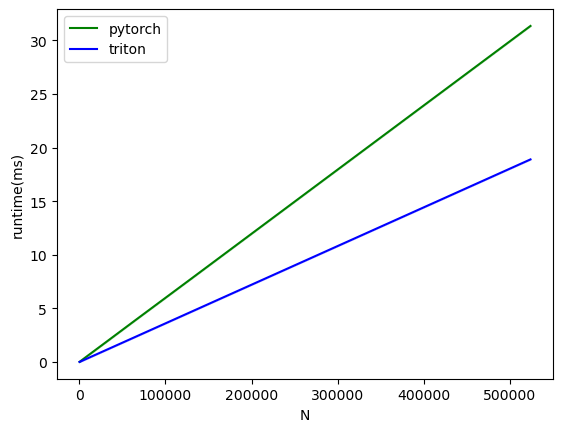

geglu-performance:
           N    pytorch     triton
0      128.0   0.014336   0.009216
1      256.0   0.020480   0.013312
2      512.0   0.036864   0.023552
3     1024.0   0.070656   0.041984
4     2048.0   0.133120   0.077824
5     4096.0   0.256000   0.151552
6     8192.0   0.503808   0.300032
7    16384.0   0.992256   0.594896
8    32768.0   1.970688   1.184768
9    65536.0   3.933184   2.364416
10  131072.0   7.837696   4.725760
11  262144.0  15.672832   9.446400
12  524288.0  31.338495  18.893824


In [25]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        line_arg="provider",
        x_vals=[2**i for i in range(7, 20)],
        line_vals=["pytorch", "triton"],
        line_names=["pytorch", "triton"],
        styles=[("green", "-"), ("blue", "-")],
        ylabel="runtime(ms)",
        plot_name="geglu-performance",
        args={"C": 4096},
    )
)
def benchmark(N, C, provider):
    x = th.rand(N, C, device="cuda")

    quantiles = [0.5, 0.2, 0.8]
    if provider == "pytorch":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: geglu_torch(x),
            quantiles=quantiles,
        )
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: geglu(x),
            quantiles=quantiles,
        )

    return ms, max_ms, min_ms


benchmark.run(show_plots=True, print_data=True)